In [1]:
%reload_ext autoreload
%autoreload 2

# Test optimization of minimization of $\log^2x$

In [5]:
import tensorflow as tf

x = tf.Variable(2, name='x', dtype=tf.float32)
log_x = tf.log(x)
log_x_squared = tf.square(log_x)

optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(log_x_squared)

init = tf.global_variables_initializer()

def optimize():
    with tf.Session() as session:
        session.run(init)
        print("starting at", "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))
        for step in range(10):  
            session.run(optimizer)
            print("step", step, "x:", session.run(x), "log(x)^2:", session.run(log_x_squared))

optimize()

starting at x: 2.0 log(x)^2: 0.480453
step 0 x: 1.6534264 log(x)^2: 0.25285786
step 1 x: 1.3493005 log(x)^2: 0.08975195
step 2 x: 1.1272697 log(x)^2: 0.014351694
step 3 x: 1.0209966 log(x)^2: 0.0004317743
step 4 x: 1.0006447 log(x)^2: 4.1534943e-07
step 5 x: 1.0000006 log(x)^2: 3.5527118e-13
step 6 x: 1.0 log(x)^2: 0.0
step 7 x: 1.0 log(x)^2: 0.0
step 8 x: 1.0 log(x)^2: 0.0
step 9 x: 1.0 log(x)^2: 0.0


# Test placeholders usage

In [ ]:
import tensorflow as tf

x = tf.Variable(1., name='x')
a = tf.placeholder(dtype=float, shape=(), name='a')

def cost():
    return tf.add(tf.square(x),a)

#train = tf.train.AdamOptimizer(0.5).minimize(cost())

init = tf.global_variables_initializer()

def optimize():
    with tf.Session() as session:
        session.run(init)
        print(session.run(cost(), feed_dict={x: 5.0, a :51.0}))


optimize()

# Train the Erdos-Renyi model

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import with_statement

import sys
sys.path.append('..')

import tensorflow as tf
import networkx as nx

import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns

from networkqit import graph_laplacian as GL
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

########## INITIALIZATION PHASE ##########
N = 100
pstar = 0.2
beta = 0.001
shape=[N, N]
G = nx.erdos_renyi_graph(N,pstar)
A = nx.to_numpy_array(G)
print('Empirical density:', nx.density(G))
L=nq.graph_laplacian(A)
rho = nq.compute_vonneuman_density(L=L,beta=beta)
lo = np.linalg.eigvalsh(L)

########## TENSORFLOW PHASE ##########
with tf.device('/device:CPU:0'):
    # Define the tensorflow optimization variable p
    p = tf.Variable(float(np.random.random()), name='p')
    
    # Convert stuff to tensorflow to create nodes in the computational graph
    beta=tf.convert_to_tensor(beta,name='beta',dtype=tf.float32)
    rho = tf.convert_to_tensor(rho,name='rho',dtype=tf.float32)
    Lobs = tf.convert_to_tensor(L,name='Lobs',dtype=tf.float32)
    lo = tf.convert_to_tensor(lo,dtype=tf.float32)
    
    # Create the sampling matrix
    rij = tf.random_uniform(shape,minval=0.0,maxval=1.0)
    rijsym = (tf.transpose(rij) + rij) / 2.0
    pij = tf.multiply(rijsym,tf.ones([N,N])-tf.eye(N))
    
    # Sample from the probabilities
    Amodel = 1/(1 + tf.exp(40*pij-40*p)) # this is like setting Amodel = pij > p as the sigmoid is similar 
    Amodel = tf.multiply(Amodel,tf.constant([1.0]) - tf.eye(shape[0])) # set the diagonal to zero
    model_density = tf.reduce_sum(Amodel) / (N * (N - 1))
    
    Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel
    Em = tf.reduce_sum(tf.multiply(Lmodel,rho))
    # Observation energy
    Eo = tf.reduce_sum(tf.multiply(Lobs,rho))
    # Model laplacian eigenvalues
    lm = tf.self_adjoint_eig(Lmodel)[0]
    # Observation laplacian eigenvalues
    #lo = tf.self_adjoint_eig(Lobs)[0]
    # Model free energy
    Fm = - tf.reduce_logsumexp(-beta*lm) / beta
    # Observation free energy
    Fo = - tf.reduce_logsumexp(-beta*lo) / beta
    # Model loglikelihood
    loglike = beta*(-Fm + Em)
    # Observation entropy
    entropy = beta*(-Fo + Eo)
    # Model relative entropy (using abs for precision purposes)
    rel_entropy = tf.abs(loglike - entropy)
    grad = tf.gradients(rel_entropy,p)

    # Define the optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    # Define the function to start optimization
    train = optimizer.minimize(rel_entropy)
    # Initialize the global variables
    #print(tf.trainable_variables())
    init = tf.global_variables_initializer()

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        session.run(init)
        all_loss,all_theta = [],[]
        epochs = 10
        print('Initial p:', session.run(p))
        for step in range(epochs):
            session.run(train)
            all_theta.append(session.run(model_density))
            all_loss.append(session.run(rel_entropy))
            g = session.run(grad)
            print('\r beta:',session.run(beta), 'step', step, 'p:',all_theta[-1],  'density:',session.run(model_density), 'loss:', all_loss[-1],'grad:',g, end='')

        plt.figure(figsize=(8,8))
        plt.imshow(session.run(1-Amodel),cmap='binary')
        plt.grid(False)
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
        ax[0].plot(all_loss)
        ax[1].plot(all_theta)
        ax[1].plot([pstar]*len(all_theta),'r-')
        plt.tight_layout()

# Train the configuration model

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import with_statement

from datetime import datetime
now = datetime.now()
tf_logdir = '/home/carlo/workspace/networkqit/tensorboard/' + now.strftime("%Y%m%d-%H%M%S") + "/"

import sys
sys.path.append('..')

import tensorflow as tf
import networkx as nx

import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

tf.logging.set_verbosity(tf.logging.INFO)
sns.set(font_scale=1.5)

tf.reset_default_graph()
g = tf.Graph()
with g.as_default(), tf.device('/device:CPU:0'):
    # Define the observed matrix (using the karate club)
    N = 50
    beta = 1*1E-2
    #G = nx.erdos_renyi_graph(N,pstar)
    #G = nx.karate_club_graph()
    #G = nx.planted_partition_graph(4,10,0.8,0.2)
    G = nx.barabasi_albert_graph(100,15)
    print(nx.density(G))
    avgnn = np.array(list(nx.neighbor_degree.average_neighbor_degree(G)))
    N = len(G.nodes())
    A = nx.to_numpy_array(G)
    shape=[N, N]
    m = A.sum()
    L=np.diag(A.sum(axis=0))-A
    rho = nq.compute_vonneuman_density(L=L,beta=beta)
    
    # Convert stuff to tensorflow to create nodes in the computational graph
    beta=tf.convert_to_tensor(beta,name='beta',dtype=tf.float64)
    rho = tf.convert_to_tensor(rho,name='rho',dtype=tf.float64)
    Lobs = tf.convert_to_tensor(L,name='Lobs',dtype=tf.float64)
    
    # Define the tensorflow optimization variable x
    xi = tf.Variable(tf.random_uniform(shape=[N,],dtype=tf.float64), name='xi',dtype=tf.float64)
    # sampling phase, create the sampled matrix Amodel
    rij = tf.random_uniform(shape,minval=0.0, maxval=1.0,dtype=tf.float64)
    rij = (tf.transpose(rij)+rij) / 2.0
    rij = tf.multiply(rij,tf.constant([1.0],dtype=tf.float64)-tf.eye(N,dtype=tf.float64))
    
    xij = tf.einsum('i,j->ij', xi, xi) # outer product
    pij = xij / (1.0 + xij)
    Amodel = 1.0 / (1.0 + tf.exp(50*rij-50*pij)) # this is like setting < to 0 and > to 1
    Amodel = tf.multiply(Amodel,tf.constant([1.0],dtype=tf.float64)-tf.eye(shape[0],dtype=tf.float64)) # set diagonal to zero
    # Compute the model density
    model_density = tf.reduce_sum(Amodel)/(N * (N-1))
    #Amodel = bernoulli_adj(p,[N,N])
    #Amodel = tf.distributions.Bernoulli(probs=tf.constant(p,shape=[N,N]))
    
    Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel
    deltaL = m - tf.reduce_sum(Amodel)
    # Model energy

    Em = tf.reduce_sum(tf.multiply(Lmodel,rho,name='Lmrho'),name='TrLmrho')
    # Observation energy
    Eo = tf.reduce_sum(tf.multiply(Lobs,rho,name='Lobsrho'),name='TrL_orho')
    # Model laplacian eigenvalues
    lm = tf.linalg.eigvalsh(Lmodel,name='lambda_model')
    # Observation laplacian eigenvalues
    lo = tf.linalg.eigvalsh(Lobs,name='lambda_obs')
    # Model free energy
    Fm = -tf.reduce_logsumexp(-beta*lm,name='Fm') / beta
    # Observation free energy
    Fo = -tf.reduce_logsumexp(-beta*lo,name='Fo') / beta

    loglike = beta*(-Fm + Em)
    entropy = beta*(-Fo + Eo)
    rel_entropy = tf.abs(loglike - entropy)
    grad = tf.gradients(rel_entropy,xi)

    # Define the optimizer
    train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(rel_entropy)
    # Initialize the global variables
    init = tf.global_variables_initializer()
    # Create a summary to monitor cost tensor
    tf.summary.scalar('loss_logger', rel_entropy)
    tf.summary.scalar('deltam_logger', deltaL)
    tf.summary.histogram('xi_logger',xi)
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()

    # Run the computational graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        # op to write logs to Tensorboard
        writer = tf.summary.FileWriter(tf_logdir, session.graph)
        session.run(init)
        all_loss,alldeltaL = [], []
        epochs = 2000
        ##### Start the training
        for step in range(epochs):
            ########## Tensorflow logging ##########
            session.run(train)
            summary = session.run(merged_summary_op)
            #print(summary,step)
            writer.add_summary(summary, step)
            
            ####### Matplotlib logging #######
            all_loss.append(session.run(rel_entropy))
            alldeltaL.append(session.run(deltaL))
            # Write logs at every iteration
            #summary_writer.add_summary(summary, step )
            writer.flush()
            print('\r beta:',session.run(beta), 'step', step,  'density:',session.run(model_density), 'deltam:', session.run(deltaL) ,'loss:', all_loss[-1],end='')
        writer.close()
        fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,9))
        ax[0,0].plot(all_loss)
        ax[0,0].set_title('Relative entropy')
        ax[0,0].set_xlabel('iteration')
        ax[0,1].plot(A.sum(axis=0),'r-')
        ax[0,1].set_title('Degree')
        ax[0,1].set_xlabel('node')
        ax[0,1].set_ylabel('degree')
        ax[0,1].plot(session.run(Amodel).sum(axis=0),'b.')
        ax[0,2].plot(alldeltaL)
        ax[0,2].set_title('$\Delta m$')
        
        ax[1,0].plot(range(0,N),avgnn,'r-')
        ax[1,0].plot(range(0,N),np.array(list(nx.neighbor_degree.average_neighbor_degree(nx.from_numpy_array(session.run(Amodel))))),'b.')
        ax[1,0].set_title('Average neighbor degree')
        ax[1,0].set_xlabel('node')
        ax[1,0].set_ylabel('avg.neigh.deg')
        plt.tight_layout()

0.25757575757575757
 beta: 0.01 step 1999 density: 0.09593913174879214 deltam: 1641.3878377920387 loss: 0.0014261030491606874

# Train the configuration model using placeholders

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import with_statement

from datetime import datetime
now = datetime.now()
tf_logdir = '/home/carlo/workspace/networkqit/tensorboard/' + now.strftime("%Y%m%d-%H%M%S") + "/"

import sys
sys.path.append('..')

import tensorflow as tf
import networkx as nx

import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
sns.set(font_scale=1.5)

### Tensorflow stuff
tf.logging.set_verbosity(tf.logging.INFO)
tf.reset_default_graph()
g = tf.Graph()
with tf.device('/device:CPU:0'):
    
    N = 50
    beta = 0.2 * 1E-3
    G = nx.barabasi_albert_graph(N,5)
    A = nx.to_numpy_array(G)
    shape=[N, N]
    Lobs = nq.graph_laplacian(A)
        
    xi =  tf.Variable(tf.random_uniform(shape=[N,]), name='xi')
    # sampling phase, create the random probabilities of sampling R
    rij = tf.random_uniform(shape,minval=0.0, maxval=1.0)
    rij = (tf.transpose(rij) + rij) / 2.0
    rij = tf.multiply(rij,tf.constant([1.0])-tf.eye(shape[0]))

    xij = tf.einsum('i,j->ij', xi, xi) # outer product
    pij = xij / (1.0 + xij)
    # Create the model adjacency matrix by sampling from pij with probabilities rij
    Amodel = 1.0 / (1.0 + tf.exp(50*rij-50*pij)) # this is like setting < to 0 and > to 1
    # Set the diagonal to zero
    Amodel = tf.multiply(Amodel,tf.constant([1.0])-tf.eye(shape[0])) # set diagonal to zero
    # Compute the model Laplacian
    tf_Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel
    
    
    # Model energy
    Em = tf.reduce_sum(tf.multiply(tf_Lmodel,tf_rho,name='Lmrho'), name='TrLmrho')
    # Observation energy
    Eo = tf.reduce_sum(tf.multiply(tf_Lobs,tf_rho,name='Lobsrho'), name='TrL_orho')
    # Model laplacian eigenvalues
    lm = tf.linalg.eigvalsh(tf_Lmodel,name='lambda_model')
    # Observation laplacian eigenvalues
    lo = tf.linalg.eigvalsh(tf_Lobs,name='lambda_obs')
    # Model free energy
    Fm = - tf.reduce_logsumexp(-tf_beta*lm,name='Fm') / tf_beta
    # Observation free energy
    Fo = - tf.reduce_logsumexp(-tf_beta*lo,name='Fo') / tf_beta
    # Loglikelihood and relative entropy to train
    loglike = beta*(-Fm + Em)
    entropy = beta*(-Fo + Eo)
    rel_entropy = tf.abs(loglike - entropy)
        
    # Compute the model density
    #model_density = tf.trace(Lmodel)/(N * (N-1))
    #deltaL = np.trace(Lobs) - tf.reduce_sum(Amodel)

    grad = tf.gradients(rel_entropy,xi)
    merged_summary_op = tf.summary.merge_all()
    # Create a summary to monitor cost tensor
    #tf.summary.scalar('loss_logger', rel_entropy)
    #tf.summary.scalar('deltam_logger', deltaL)
    #tf.summary.histogram('xi_logger',xi)
        
    train = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss())
        
    
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        # Operations to write logs to Tensorboard
        session.run(tf.global_variables_initializer())
        #writer = tf.summary.FileWriter(tf_logdir, session.graph)
        for beta in np.logspace(-2,2,10):
            # Initialize the global variables
            for epoch in range(0,100):
                session.run(train,feed_dict={'beta': beta, 'rho': nq.compute_vonneuman_density(L=Lobs,beta=beta), 'Lobs': Lobs })
                print(session.run(xi))

# Train the configuration model with decreasing $\beta$

In [ ]:
from __future__ import with_statement

tf_logdir = '/tmp/'


import tensorflow as tf
import networkx as nx

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

from scipy.linalg import expm

def graph_laplacian(A):
    return np.diag(A.sum(axis=0))-A

def vonneumann_density(L,beta):
    rho = expm(-L*beta)
    return rho/np.trace(rho)
tf.reset_default_graph()
g = tf.Graph()
with g.as_default(), tf.device('/device:CPU:0'):
    # Define the observed matrix (using the karate club)
    N = 50
    beta = 1*1E-2
    #G = nx.erdos_renyi_graph(N,pstar)
    #G = nx.karate_club_graph()
    #G = nx.planted_partition_graph(4,10,0.8,0.2)
    G = nx.barabasi_albert_graph(100,15)
    avgnn = np.array(list(nx.neighbor_degree.average_neighbor_degree(G)))
    N = len(G.nodes())
    A = nx.to_numpy_array(G)
    shape=[N, N]
    m = A.sum()
    L=np.diag(A.sum(axis=0))-A
    rho = vonneumann_density(L=L,beta=beta)
    
    # Convert stuff to tensorflow to create nodes in the computational graph
    beta=tf.convert_to_tensor(beta,name='beta',dtype=tf.float64)
    rho = tf.convert_to_tensor(rho,name='rho',dtype=tf.float64)
    Lobs = tf.convert_to_tensor(L,name='Lobs',dtype=tf.float64)
    
    # Define the tensorflow optimization variable x
    xi = tf.Variable(tf.random_uniform(shape=[N,],dtype=tf.float64), name='xi',dtype=tf.float64)
    # sampling phase, create the sampled matrix Amodel
    rij = tf.random_uniform(shape,minval=0.0, maxval=1.0,dtype=tf.float64)
    rij = (tf.transpose(rij)+rij) / 2.0
    rij = tf.multiply(rij,tf.constant([1.0],dtype=tf.float64)-tf.eye(N,dtype=tf.float64))
    
    xij = tf.einsum('i,j->ij', xi, xi) # outer product
    pij = xij / (1.0 + xij)
    Amodel = 1.0 / (1.0 + tf.exp(50*rij-50*pij)) # this is like setting < to 0 and > to 1
    Amodel = tf.multiply(Amodel,tf.constant([1.0],dtype=tf.float64)-tf.eye(shape[0],dtype=tf.float64)) # set diagonal to zero
    # Compute the model density
    model_density = tf.reduce_sum(Amodel)/(N * (N-1))
    # Compute the model Laplacian    
    Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel
    # Monitor the difference in number of links between model and data
    deltaL = m - tf.reduce_sum(Amodel)
    
    # Model energy
    Em = tf.reduce_sum(tf.multiply(Lmodel,rho,name='Lmrho'),name='TrLmrho')
    # Observation energy
    Eo = tf.reduce_sum(tf.multiply(Lobs,rho,name='Lobsrho'),name='TrL_orho')
    # Model laplacian eigenvalues
    lm = tf.linalg.eigvalsh(Lmodel,name='lambda_model')
    # Observation laplacian eigenvalues
    lo = tf.linalg.eigvalsh(Lobs,name='lambda_obs')
    # Model free energy
    Fm = -tf.reduce_logsumexp(-beta*lm,name='Fm') / beta
    # Observation free energy
    Fo = -tf.reduce_logsumexp(-beta*lo,name='Fo') / beta

    loglike = beta*(-Fm + Em)
    entropy = beta*(-Fo + Eo)
    rel_entropy = tf.abs(loglike - entropy)
    grad = tf.gradients(rel_entropy,xi)

    # Define the optimizer
    train = tf.train.AdamOptimizer(learning_rate=0.01).minimize(rel_entropy)
    # Initialize the global variables
    init = tf.global_variables_initializer()

    # Run the computational graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        # op to write logs to Tensorboard
        writer = tf.summary.FileWriter(tf_logdir, session.graph)
        session.run(init)
        all_loss,alldeltaL = [], []
        for beta in np.logspace(2,-2,10):
            epochs = 200
            ##### Start the training
            for step in range(epochs):
                ########## Tensorflow logging ##########
                session.run(train)

                ####### Matplotlib logging #######
                all_loss.append(session.run(rel_entropy))
                alldeltaL.append(session.run(deltaL))
                # Write logs at every iteration
                print('\r beta:',session.run(beta), 'step', step,  'density:',session.run(model_density), 'deltam:', session.run(deltaL) ,'loss:', all_loss[-1],end='')

        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,9))
        ax[0].plot(all_loss)
        ax[0].set_title('Relative entropy')
        ax[0].set_xlabel('iteration')
        ax[1].plot(A.sum(axis=0),'r-')
        ax[1].set_title('Degree')
        ax[1].set_xlabel('node')
        ax[1].set_ylabel('degree')
        ax[1].plot(session.run(Amodel).sum(axis=0),'b.')
        ax[2].plot(alldeltaL)
        ax[2].set_title('$\Delta m$')
        
        plt.tight_layout()

In [ ]:
from __future__ import with_statement
import tensorflow as tf
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import expm

tf.reset_default_graph()
x = tf.Variable(2.0,dtype=tf.float64)
# Initialize the global variables
init = tf.global_variables_initializer()
        
def log_x(beta):
    return (x-beta)**2
        
with tf.Session() as sess:
    sess.run(init)
    for npbeta in np.logspace(2,-2,5):
        beta=tf.convert_to_tensor(npbeta,name='beta',dtype=tf.float64)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(log_x(beta))
        print(sess.run(optimizer))
        #print(sess.run(x))

In [ ]:
import tensorflow as tf

init = tf.global_variables_initializer()
tf.reset_default_graph()

x = tf.Variable(2.0,dtype=tf.float64)
with tf.Session() as sess:
    sess.run(init)
    def f(a):
        return (x-a)**2
    for aval in range(0,4):
        
        a =  tf.convert_to_tensor(aval,name='a',dtype=tf.float64)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(f(beta))
        
        for epochs in range(0,10):
            sess.run(optimizer)
        print(sess.run(x))
        # How to initialize x for the next value of a using the current x?

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import with_statement

import sys
sys.path.append('..')

import tensorflow as tf
import networkx as nx

import numpy as np
import networkqit as nq
import networkx as nx

from networkqit import graph_laplacian as GL
import matplotlib.pyplot as plt
plt.style.use('ggplot')
print(plt.style.available)
tf.reset_default_graph()

# Imperative part
G = nx.barabasi_albert_graph(200,5)
N = len(G.nodes())
shape=[N, N]
A = nx.to_numpy_array(G)
m = A.sum()
L= np.diag(A.sum(axis=0)) - A
print(nx.density(G))
# Deferred part
with tf.device('/device:CPU:0'):
    Lobs = tf.placeholder(dtype=tf.float64)
    beta = tf.placeholder(dtype=tf.float64)
    rho = tf.linalg.expm(-beta*Lobs)/tf.trace(tf.linalg.expm(-beta*Lobs))

    # Define the tensorflow optimization variable x
    xi = tf.Variable(tf.random_uniform(shape=[N,],dtype=tf.float64), name='xi',dtype=tf.float64)
    # sampling phase, create the sampled matrix Amodel
    rij = tf.random_uniform(shape,minval=0.0, maxval=1.0,dtype=tf.float64)
    rij = (tf.transpose(rij)+rij) / 2.0
    rij = tf.multiply(rij,tf.constant([1.0],dtype=tf.float64)-tf.eye(N,dtype=tf.float64))

    xij = tf.einsum('i,j->ij', xi, xi) # outer product
    pij = xij / (1.0 + xij)
    Amodel = 1.0 / (1.0 + tf.exp(50*rij-50*pij)) # this is like setting < to 0 and > to 1
    Amodel = tf.multiply(Amodel,tf.constant([1.0],dtype=tf.float64)-tf.eye(shape[0],dtype=tf.float64)) # set diagonal to zero
    # Compute the model density
    model_density = tf.reduce_sum(Amodel)/(N * (N-1))
    # Compute the model Laplacian    
    Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel

    # Monitor the difference in number of links between model and data
    deltaL = m - tf.reduce_sum(Amodel)

    # Model energy
    Em = tf.reduce_sum(tf.multiply(Lmodel,rho,name='Lmrho'),name='TrLmrho')
    # Observation energy
    Eo = tf.reduce_sum(tf.multiply(Lobs,rho,name='Lobsrho'),name='TrL_orho')
    # Model laplacian eigenvalues
    lm = tf.linalg.eigvalsh(Lmodel,name='lambda_model')
    # Observation laplacian eigenvalues
    lo = tf.linalg.eigvalsh(Lobs,name='lambda_obs')
    # Model free energy
    Fm = -tf.reduce_logsumexp(-beta*lm,name='Fm') / beta
    # Observation free energy
    Fo = -tf.reduce_logsumexp(-beta*lo,name='Fo') / beta

    loglike = beta*(-Fm + Em)
    entropy = beta*(-Fo + Eo)
    rel_entropy = tf.abs(loglike - entropy)
    grad = tf.gradients(rel_entropy,xi)

    # Define the optimizer
    learning_rate = tf.placeholder(dtype=tf.float64)
    train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(rel_entropy)
    # Initialize the global variables
    init = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init)
    all_loss = []
    all_deltaM = []
    beta_range = np.logspace(0,-2,10)
    nepochs = 200
    all_steps = 0
    for b in beta_range:
        for epoch in range(0,nepochs):
            feed_dict = {Lobs:L, beta:b , learning_rate: 0.01}
            sess.run(train, feed_dict = feed_dict)
            res = sess.run([beta,rel_entropy,deltaL,model_density,learning_rate,xi],feed_dict = feed_dict)
            sol = sess.run(xi,feed_dict = feed_dict)
            all_loss.append(res[1])
            all_deltaM.append(res[2])
            all_steps += 1
            # Logging
            #print(sol)
            print('\rDone:%.1f%%\tEpoch:%d\tbeta: %.2g\tLoss: %.2g\tDeltaL: %.2f\tDensity: %.2f\tlearning_rate: %g' % (100.0*all_steps/(len(beta_range)*nepochs),epoch,res[0],res[1],res[2],res[3],res[4]), end='')
    # Plotting part
    fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(24,8))
    for i,b in enumerate(beta_range):
        ax[0].plot(np.linspace(i*nepochs,(i+1)*nepochs,nepochs),all_loss[i*nepochs:(i+1)*nepochs])
    ax[0].set_title('Relative entropy')
    ax[0].set_xlabel('Iteration')
    for i,b in enumerate(beta_range):
        ax[1].plot(np.linspace(i*nepochs,(i+1)*nepochs,nepochs),all_deltaM[i*nepochs:(i+1)*nepochs])
    ax[1].set_title('$\\Delta m$')
    ax[1].set_xlabel('Iteration')
    ax[2].bar(range(0,N),A.sum(axis=0) - np.diagonal(sess.run(Lmodel)))

In [ ]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(24,8))
for i,b in enumerate(beta_range):
    ax[0].plot(all_loss)
ax[0].set_title('Relative entropy')
ax[0].set_xlabel('Iteration')
for i,b in enumerate(beta_range):
    ax[1].plot(np.linspace(i*nepochs,(i+1)*nepochs,nepochs),all_deltaM[i*nepochs:(i+1)*nepochs])
ax[1].set_title('$\\Delta m$')
ax[1].set_xlabel('Iteration')

# Optimize with rank 3 tensors for average computations

In [17]:
rij = tf.random_uniform([5,3,3],minval=0.0, maxval=1.0,dtype=tf.float64)
rij = tf.transpose(rij,perm=[1,0,2])
#rij = tf.multiply(rij,tf.constant([1.0],dtype=tf.float64)-tf.eye(N,dtype=tf.float64))

#xij = tf.einsum('i,j->ij', xi, xi) # outer product
#pij = xij / (1.0 + xij)
with tf.Session() as sess:
    print(sess.run(rij))

[[[0.32126794 0.14115253 0.26004761]
  [0.67523337 0.80293198 0.66460198]
  [0.86265688 0.03264781 0.35948892]
  [0.1409615  0.8445218  0.85864481]
  [0.44119456 0.91657969 0.73084892]]

 [[0.67430261 0.00274999 0.3963009 ]
  [0.65592621 0.88959513 0.03193265]
  [0.58646855 0.85013366 0.31007237]
  [0.33126062 0.409825   0.22091466]
  [0.76124551 0.27331217 0.97400066]]

 [[0.96249221 0.44727626 0.16580044]
  [0.04498564 0.59901964 0.86155191]
  [0.6173706  0.65705152 0.0263448 ]
  [0.35597642 0.68251832 0.59008555]
  [0.56489831 0.45149586 0.3233941 ]]]


0.048994974874371856
Done:100.0%	Epoch:9	beta: 0.001	Loss: 5.8e-06	DeltaL: 2.30	Density: 0.05	learning_rate: 0.01

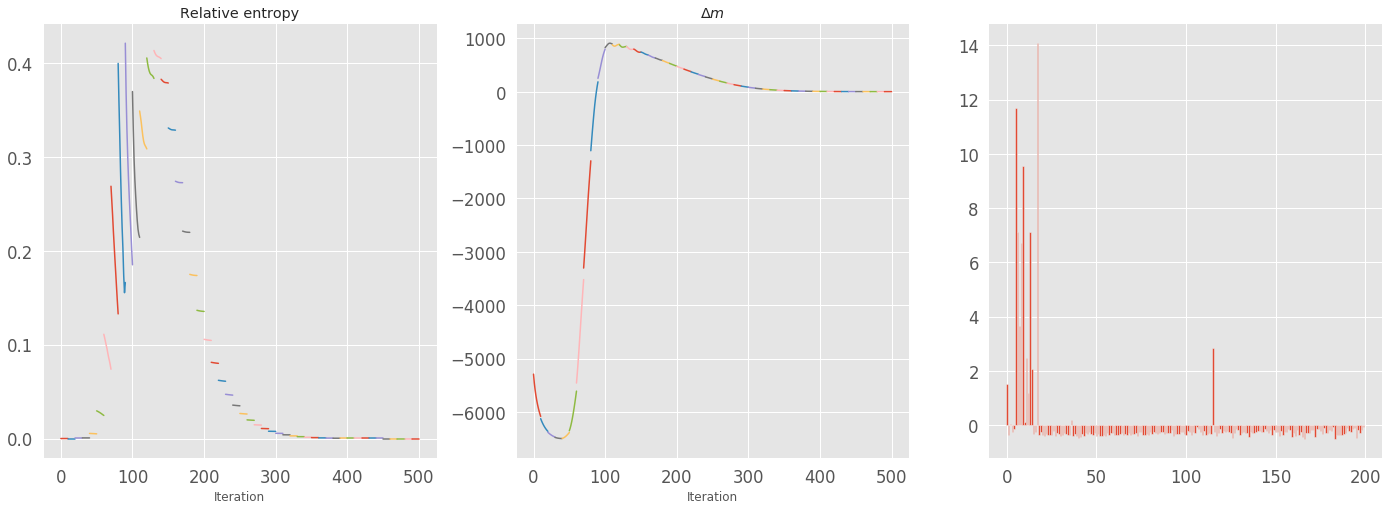

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import with_statement

import sys
sys.path.append('..')

import tensorflow as tf
import networkx as nx

import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns

from networkqit import graph_laplacian as GL
import matplotlib.pyplot as plt
plt.style.use('ggplot')

tf.reset_default_graph()

# Imperative part
G = nx.barabasi_albert_graph(200,5)
N = len(G.nodes())
shape=[N, N]
A = nx.to_numpy_array(G)
m = A.sum()
L= np.diag(A.sum(axis=0)) - A
print(nx.density(G))
# Deferred part
mini_batch_size = 2
with tf.device('/device:CPU:0'):
    Lobs = tf.placeholder(dtype=tf.float64)
    beta = tf.placeholder(dtype=tf.float64)
    rho = tf.linalg.expm(-beta*Lobs)/tf.trace(tf.linalg.expm(-beta*Lobs))

    # Define the tensorflow optimization variable x
    xi = tf.Variable(tf.random_uniform(shape=[N,],dtype=tf.float64), name='xi',dtype=tf.float64)
    # sampling phase, create the sampled matrix Amodel
    rij = tf.random_uniform(shape,minval=0.0, maxval=1.0,dtype=tf.float64)
    rij = (tf.transpose(rij)+rij) / 2.0
    rij = tf.multiply(rij,tf.constant([1.0],dtype=tf.float64)-tf.eye(N,dtype=tf.float64))

    xij = tf.einsum('i,j->ij', xi, xi) # outer product
    pij = xij / (1.0 + xij)
    Amodel = pij
    #Amodel = 1.0 / (1.0 + tf.exp(50*rij-50*pij)) # this is like setting < to 0 and > to 1
    #Amodel = tf.multiply(Amodel,tf.constant([1.0],dtype=tf.float64)-tf.eye(shape[0],dtype=tf.float64)) # set diagonal to zero
    # Compute the model density
    model_density = tf.reduce_sum(Amodel)/(N * (N-1))
    # Compute the model Laplacian    
    Lmodel = tf.diag(tf.reduce_sum(Amodel,axis=0)) - Amodel

    # Monitor the difference in number of links between model and data
    deltaL = m - tf.reduce_sum(Amodel)

    # Model energy
    Em = tf.reduce_sum(tf.multiply(Lmodel,rho,name='Lmrho'),name='TrLmrho')
    # Observation energy
    Eo = tf.reduce_sum(tf.multiply(Lobs,rho,name='Lobsrho'),name='TrL_orho')
    # Model laplacian eigenvalues
    lm = tf.linalg.eigvalsh(Lmodel,name='lambda_model')
    # Observation laplacian eigenvalues
    lo = tf.linalg.eigvalsh(Lobs,name='lambda_obs')
    # Model free energy
    Fm = -tf.reduce_logsumexp(-beta*lm,name='Fm') / beta
    # Observation free energy
    Fo = -tf.reduce_logsumexp(-beta*lo,name='Fo') / beta

    loglike = beta*(-Fm + Em)
    entropy = beta*(-Fo + Eo)
    rel_entropy = tf.abs(loglike - entropy)
    grad = tf.gradients(rel_entropy,xi)

    # Define the optimizer
    learning_rate = tf.placeholder(dtype=tf.float64)
    train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(rel_entropy)
    # Initialize the global variables
    init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    all_loss = []
    all_deltaM = []
    beta_range = np.logspace(1,-3,50)
    nepochs = 10
    all_steps = 0
    for b in beta_range:
        for epoch in range(0,nepochs):
            feed_dict = {Lobs:L, beta:b , learning_rate: 0.01}
            sess.run(train, feed_dict = feed_dict)
            res = sess.run([beta,rel_entropy,deltaL,model_density,learning_rate,xi],feed_dict = feed_dict)
            sol = sess.run(xi,feed_dict = feed_dict)
            all_loss.append(res[1])
            all_deltaM.append(res[2])
            all_steps += 1
            # Logging
            #print(sol)
            print('\rDone:%.1f%%\tEpoch:%d\tbeta: %.2g\tLoss: %.2g\tDeltaL: %.2f\tDensity: %.2f\tlearning_rate: %g' % (100.0*all_steps/(len(beta_range)*nepochs),epoch,res[0],res[1],res[2],res[3],res[4]), end='')
    # Plotting part
    fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(24,16))
    for i,b in enumerate(beta_range):
        ax[0,0].plot(np.linspace(i*nepochs,(i+1)*nepochs,nepochs),all_loss[i*nepochs:(i+1)*nepochs])
    ax[0,0].set_title('Relative entropy')
    ax[0,0].set_xlabel('Iteration')
    for i,b in enumerate(beta_range):
        ax[1,0].plot(np.linspace(i*nepochs,(i+1)*nepochs,nepochs),all_deltaM[i*nepochs:(i+1)*nepochs])
    ax[1,0].set_title('$\\Delta m$')
    ax[1,0].set_xlabel('Iteration')
    ax[1,1].bar(range(0,N),A.sum(axis=0) - np.diagonal(sess.run(Lmodel)))
    ax[0,1].semilogx(beta_range,)

In [10]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type=='CPU']
get_available_devices()

['/device:CPU:0']